In [1]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap

from data.get_uci import all_datasets
from analysis.util import fetch, init_uci_dict, get_uci_info

uci_info = get_uci_info()

In [2]:
filters = {
    "group": "noise"
}
raw = fetch("soft-gp-3", filters)

100%|██████████| 36/36 [00:13<00:00,  2.73it/s]


In [3]:
runs = {}
uci_dict = {}
for exp in raw:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    num_inducing = exp.config["model.num_inducing"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    learn_noise = exp.config["model.learn_noise"]
    train_frac = float(exp.config["dataset.train_frac"])
    uci_dict[(dataset, seed, num_inducing, train_frac, model, learn_noise)] = exp.history
    runs[(dataset, seed, num_inducing, train_frac, model, learn_noise)] = exp.run.id

print(uci_dict.keys())

dict_keys([('houseelectric', 92357, 512, 0.9, 'soft-gp', True), ('houseelectric', 8830, 512, 0.9, 'soft-gp', True), ('houseelectric', 6535, 512, 0.9, 'soft-gp', True), ('buzz', 92357, 512, 0.9, 'soft-gp', True), ('buzz', 8830, 512, 0.9, 'soft-gp', True), ('buzz', 6535, 512, 0.9, 'soft-gp', True), ('song', 92357, 512, 0.9, 'soft-gp', True), ('song', 8830, 512, 0.9, 'soft-gp', True), ('song', 6535, 512, 0.9, 'soft-gp', True), ('3droad', 92357, 512, 0.9, 'soft-gp', True), ('3droad', 8830, 512, 0.9, 'soft-gp', True), ('3droad', 6535, 512, 0.9, 'soft-gp', True), ('keggundirected', 92357, 512, 0.9, 'soft-gp', True), ('keggundirected', 8830, 512, 0.9, 'soft-gp', True), ('keggundirected', 6535, 512, 0.9, 'soft-gp', True), ('slice', 92357, 512, 0.9, 'soft-gp', True), ('slice', 8830, 512, 0.9, 'soft-gp', True), ('slice', 6535, 512, 0.9, 'soft-gp', True), ('keggdirected', 92357, 512, 0.9, 'soft-gp', True), ('keggdirected', 8830, 512, 0.9, 'soft-gp', True), ('keggdirected', 6535, 512, 0.9, 'soft-g

In [12]:
filters = {
    "group": "benchmark"
}
raw_orig = fetch("soft-gp-3", filters)

100%|██████████| 87/87 [00:36<00:00,  2.37it/s]


In [13]:
runs2 = {}
uci_dict2 = {}
for exp in raw_orig:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    num_inducing = exp.config["model.num_inducing"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    train_frac = float(exp.config["dataset.train_frac"])
    if model == "svi-gp" and not exp.config["model.learn_noise"]:
        continue 
    if model == "sv-gp" and not exp.config["model.learn_noise"]:
        continue 
    uci_dict2[(dataset, seed, num_inducing, train_frac, model)] = exp.history
    runs2[(dataset, seed, num_inducing, train_frac, model)] = exp.run.id

In [14]:
seeds = [6535, 8830, 92357]
num_inducings = [512, 1024]
fracs = [0.9]

UCI_INFO = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
}
KZZ = {}
all_bins = {}

models = ["soft-gp"]

for seed in seeds:
    for model in models:
        for num_inducing in num_inducings:
            for frac in fracs:
                xs = []
                ts = []
                K_zzs = []
                bins1 = []
                bins2 = []
                bins3 = []
                bins4 = []
                bins5 = []
                bins6 = []
                for dataset, _, _, _ in uci_info:
                    try:
                        xs += [float(uci_dict2[(dataset, seed, num_inducing, frac, model)]["test_rmse"][49])]
                        ts += [float(np.array(uci_dict2[(dataset, seed, num_inducing, frac, model)]["epoch_time"][49]).mean())]
                        K_zzs += [uci_dict2[(dataset, seed, num_inducing, frac, model)]["K_zz"][i] for i in range(5)]
                        bins1 += [uci_dict2[(dataset, seed, num_inducing, frac, model)]["K_zz_bin_0.0"][49]]
                        bins2 += [uci_dict2[(dataset, seed, num_inducing, frac, model)]["K_zz_bin_1e-20"][49]]
                        bins3 += [uci_dict2[(dataset, seed, num_inducing, frac, model)]["K_zz_bin_1e-10"][49]]
                        bins4 += [uci_dict2[(dataset, seed, num_inducing, frac, model)]["K_zz_bin_1e-05"][49]]
                        bins5 += [uci_dict2[(dataset, seed, num_inducing, frac, model)]["K_zz_bin_0.01"][49]]
                        bins6 += [uci_dict2[(dataset, seed, num_inducing, frac, model)]["K_zz_bin_0.5"][49]]
                    except Exception as e:
                        xs += [np.nan]
                        ts += [np.nan]
                        bins1 += [np.nan]
                        bins2 += [np.nan]
                        bins3 += [np.nan]
                        bins4 += [np.nan]
                        bins5 += [np.nan]
                        bins6 += [np.nan]
                        print("Exception", e, model, dataset)

                UCI_INFO[f"{model}-{num_inducing}-{frac}-{seed}"] = xs
                # UCI_INFO[f"time-{model}-{num_inducing}-{frac}-{seed}"] = ts
                all_bins[f"0.0-{model}-{num_inducing}-{frac}-{seed}"] = bins1
                all_bins[f"1e-20-{model}-{num_inducing}-{frac}-{seed}"] = bins2
                all_bins[f"1e-10-{model}-{num_inducing}-{frac}-{seed}"] = bins3
                all_bins[f"1e-05-{model}-{num_inducing}-{frac}-{seed}"] = bins4
                all_bins[f"0.01-{model}-{num_inducing}-{frac}-{seed}"] = bins5
                all_bins[f"0.5-{model}-{num_inducing}-{frac}-{seed}"] = bins6
                KZZ[f"kzz-{model}-{num_inducing}-{frac}-{seed}"] = K_zzs
df = pd.DataFrame(data=UCI_INFO)
df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

Exception ('pol', 6535, 1024, 0.9, 'soft-gp') soft-gp pol
Exception ('elevators', 6535, 1024, 0.9, 'soft-gp') soft-gp elevators
Exception ('bike', 6535, 1024, 0.9, 'soft-gp') soft-gp bike
Exception ('kin40k', 6535, 1024, 0.9, 'soft-gp') soft-gp kin40k
Exception ('protein', 6535, 1024, 0.9, 'soft-gp') soft-gp protein
Exception ('keggdirected', 6535, 1024, 0.9, 'soft-gp') soft-gp keggdirected
Exception ('slice', 6535, 1024, 0.9, 'soft-gp') soft-gp slice
Exception ('keggundirected', 6535, 1024, 0.9, 'soft-gp') soft-gp keggundirected
Exception ('3droad', 6535, 1024, 0.9, 'soft-gp') soft-gp 3droad
Exception ('song', 6535, 1024, 0.9, 'soft-gp') soft-gp song
Exception ('buzz', 6535, 1024, 0.9, 'soft-gp') soft-gp buzz
Exception ('houseelectric', 6535, 1024, 0.9, 'soft-gp') soft-gp houseelectric
Exception ('buzz', 8830, 512, 0.9, 'soft-gp') soft-gp buzz
Exception ('houseelectric', 8830, 512, 0.9, 'soft-gp') soft-gp houseelectric
Exception ('pol', 8830, 1024, 0.9, 'soft-gp') soft-gp pol
Exceptio

,N,D,soft-gp-512-0.9-6535,soft-gp-1024-0.9-6535,soft-gp-512-0.9-8830,soft-gp-1024-0.9-8830,soft-gp-512-0.9-92357,soft-gp-1024-0.9-92357
Pol,13500,26,0.189323,NaN,0.202581,NaN,NaN,NaN
Elevators,14939,18,0.391446,NaN,0.397864,NaN,NaN,NaN
Bike,15641,17,0.207511,NaN,0.207647,NaN,NaN,NaN
Kin40k,36000,8,0.242929,NaN,0.228314,NaN,NaN,NaN
Protein,41157,9,0.657446,NaN,0.638127,NaN,NaN,NaN
Keggdirected,43944,20,0.078620,NaN,0.077221,NaN,NaN,NaN
Slice,48150,385,0.019602,NaN,0.018154,NaN,NaN,NaN
Keggundirected,57247,27,0.115445,NaN,0.111015,NaN,NaN,NaN
3droad,391386,3,0.607416,NaN,0.607177,NaN,NaN,NaN
Song,270000,90,0.798511,NaN,0.790525,NaN,NaN,NaN


In [15]:
seeds = [6535, 8830, 92357]

for ln in [True]:
    model = "soft-gp"
    for seed in seeds:
        frac = 0.9
        num_inducing = 512
        xs = []
        ts = []
        K_zzs = []
        bins1 = []
        bins2 = []
        bins3 = []
        bins4 = []
        bins5 = []
        bins6 = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [float(uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["test_rmse"][49])]
                ts += [float(np.array(uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["epoch_time"][49]).mean())]
                K_zzs += [uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["K_zz"][i] for i in range(5)]
                bins1 += [uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["K_zz_bin_0.0"][49]]
                bins2 += [uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["K_zz_bin_1e-20"][49]]
                bins3 += [uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["K_zz_bin_1e-10"][49]]
                bins4 += [uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["K_zz_bin_1e-05"][49]]
                bins5 += [uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["K_zz_bin_0.01"][49]]
                bins6 += [uci_dict[(dataset, seed, num_inducing, frac, model, ln)]["K_zz_bin_0.5"][49]]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                bins1 += [np.nan]
                bins2 += [np.nan]
                bins3 += [np.nan]
                bins4 += [np.nan]
                bins5 += [np.nan]
                bins6 += [np.nan]
                print("Exception", e, model, dataset)

        UCI_INFO[f"{model}-{num_inducing}-{frac}-{ln}-{seed}"] = xs
        # UCI_INFO[f"time-{model}-{num_inducing}-{frac}-{seed}-{ln}"] = ts
        all_bins[f"0.0-{model}-{num_inducing}-{frac}-{ln}-{seed}"] = bins1
        all_bins[f"1e-20-{model}-{num_inducing}-{frac}-{ln}-{seed}"] = bins2
        all_bins[f"1e-10-{model}-{num_inducing}-{frac}-{ln}-{seed}"] = bins3
        all_bins[f"1e-05-{model}-{num_inducing}-{frac}-{ln}-{seed}"] = bins4
        all_bins[f"0.01-{model}-{num_inducing}-{frac}-{ln}-{seed}"] = bins5
        all_bins[f"0.5-{model}-{num_inducing}-{frac}-{ln}-{seed}"] = bins6
        KZZ[f"kzz-{model}-{num_inducing}-{ln}-{frac}-{seed}"] = K_zzs
df = pd.DataFrame(data=UCI_INFO)
df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

,N,D,soft-gp-512-0.9-6535,soft-gp-1024-0.9-6535,soft-gp-512-0.9-8830,soft-gp-1024-0.9-8830,soft-gp-512-0.9-92357,soft-gp-1024-0.9-92357,soft-gp-512-0.9-True-6535,soft-gp-512-0.9-True-8830,soft-gp-512-0.9-True-92357
Pol,13500,26,0.189323,NaN,0.202581,NaN,NaN,NaN,0.230126,0.239367,0.242368
Elevators,14939,18,0.391446,NaN,0.397864,NaN,NaN,NaN,0.390320,0.398951,0.391026
Bike,15641,17,0.207511,NaN,0.207647,NaN,NaN,NaN,0.248242,0.251183,0.248085
Kin40k,36000,8,0.242929,NaN,0.228314,NaN,NaN,NaN,0.395756,0.389276,0.391065
Protein,41157,9,0.657446,NaN,0.638127,NaN,NaN,NaN,0.727485,0.722571,0.729303
Keggdirected,43944,20,0.078620,NaN,0.077221,NaN,NaN,NaN,0.082931,0.081435,0.089628
Slice,48150,385,0.019602,NaN,0.018154,NaN,NaN,NaN,0.023938,0.022800,0.031442
Keggundirected,57247,27,0.115445,NaN,0.111015,NaN,NaN,NaN,0.118888,0.115054,0.121061
3droad,391386,3,0.607416,NaN,0.607177,NaN,NaN,NaN,0.817974,0.816615,0.816403
Song,270000,90,0.798511,NaN,0.790525,NaN,NaN,NaN,0.805808,0.799194,0.797270


In [16]:
def pm_var(df, model):
    m = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].mean(axis=1).round(3).astype(str)
    v = df[[f'{model}-6535', f'{model}-8830', f'{model}-92357']].std(axis=1).round(3).astype(str).apply(lambda x: f" $\pm$ {x}")
    return (m + v).apply(lambda x: x.replace("nan $\pm$ nan", "-"))
df_rmse = pd.DataFrame()
df_rmse[['N', 'D']] = df[['N', 'D']]
for model in models:
    for num_inducing in [512]:
        for frac in fracs:
            df_rmse[f'{model}-{num_inducing}-{frac}'] = pm_var(df, f'{model}-{num_inducing}-{frac}')
            df_rmse[f'{model}-{num_inducing}-{frac}-{True}'] = pm_var(df, f'{model}-{num_inducing}-{frac}-{True}')

df_rmse = df_rmse.sort_values(by=['D'], ascending=[True])
df_rmse = df_rmse.drop(columns=['D', 'N'])
print("RMSE")
df_rmse

RMSE


,soft-gp-512-0.9,soft-gp-512-0.9-True
3droad,0.607 $\pm$ 0.0,0.817 $\pm$ 0.001
Kin40k,0.236 $\pm$ 0.01,0.392 $\pm$ 0.003
Protein,0.648 $\pm$ 0.014,0.726 $\pm$ 0.003
Houseelectric,0.055 $\pm$ nan,0.07 $\pm$ 0.0
Bike,0.208 $\pm$ 0.0,0.249 $\pm$ 0.002
Elevators,0.395 $\pm$ 0.005,0.393 $\pm$ 0.005
Keggdirected,0.078 $\pm$ 0.001,0.085 $\pm$ 0.004
Pol,0.196 $\pm$ 0.009,0.237 $\pm$ 0.006
Keggundirected,0.113 $\pm$ 0.003,0.118 $\pm$ 0.003
Buzz,0.248 $\pm$ nan,0.271 $\pm$ 0.002


In [17]:
latex_table = df_rmse.to_latex(
    index=True,
    escape=False,
    float_format="{:0.3f}".format,
)
print(latex_table)

\begin{tabular}{lll}
\toprule
 & soft-gp-512-0.9 & soft-gp-512-0.9-True \\
\midrule
3droad & 0.607 $\pm$ 0.0 & 0.817 $\pm$ 0.001 \\
Kin40k & 0.236 $\pm$ 0.01 & 0.392 $\pm$ 0.003 \\
Protein & 0.648 $\pm$ 0.014 & 0.726 $\pm$ 0.003 \\
Houseelectric & 0.055 $\pm$ nan & 0.07 $\pm$ 0.0 \\
Bike & 0.208 $\pm$ 0.0 & 0.249 $\pm$ 0.002 \\
Elevators & 0.395 $\pm$ 0.005 & 0.393 $\pm$ 0.005 \\
Keggdirected & 0.078 $\pm$ 0.001 & 0.085 $\pm$ 0.004 \\
Pol & 0.196 $\pm$ 0.009 & 0.237 $\pm$ 0.006 \\
Keggundirected & 0.113 $\pm$ 0.003 & 0.118 $\pm$ 0.003 \\
Buzz & 0.248 $\pm$ nan & 0.271 $\pm$ 0.002 \\
Song & 0.795 $\pm$ 0.006 & 0.801 $\pm$ 0.004 \\
Slice & 0.019 $\pm$ 0.001 & 0.026 $\pm$ 0.005 \\
\bottomrule
\end{tabular}



# Download Artifacts

In [18]:
api = wandb.Api()
for exp in tqdm(raw_orig):
    run = api.run(f'bogp/soft-gp-3/{exp.run.id}')
    if exp.config["training.seed"] == 6535:
        for artifact in run.logged_artifacts():
            print(artifact.name)
            artifact.download(root=f"noise/fixed/{artifact.name}/")

  0%|          | 0/87 [00:00<?, ?it/s]

inducing_points_svigp_houseelectric_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-0s567ogr-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-u740rifq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-l5dcs7lr-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-7nywrszm-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-4gzdtx7x-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-f95eewuq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-wefynrwd-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-5nz3qa03-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-uqrvlmee-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-i9w0pj4z-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-j0kwjn9v-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-adovh86r-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-1g38b2jq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qt11p9g9-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ejvi42f0-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-sa5ifinj-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-cz97j81p-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-13utfb8o-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ik6mjy97-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-u7isa8u2-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xmwvs19o-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qdht2pzx-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-0rtrekaj-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-srqthy6n-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-2kpq0udo-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-pji8rhqw-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-7rdi2dd3-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-gf7v6hhn-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-1zqwv91q-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-beadof8p-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xtw5oeja-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-nys448b5-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-5jck5xrl-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-c038y7ip-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-x30vej7a-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-w5c7b5fk-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-7vka34q2-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-mf48qfzh-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xm2578g1-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qvqn8sxy-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-x25do9yg-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-tconcpls-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-mb1zv7a5-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-xo96qpu4-history:v0


wandb:   1 of 1 files downloaded.  


In [19]:
api = wandb.Api()
for exp in tqdm(raw):
    run = api.run(f'bogp/soft-gp-3/{exp.run.id}')
    if exp.config["training.seed"] == 6535:
        for artifact in run.logged_artifacts():
            print(artifact.name)
            artifact.download(root=f"noise/learned/{artifact.name}/")

  0%|          | 0/36 [00:00<?, ?it/s]

inducing_points_softgp_houseelectric_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-i8d5tzk3-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-cnhka7zr-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-5l2k957x-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ewg1gkuc-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-z5d0gjbu-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-whcrowfo-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-fwy0hzkk-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-qj98qosz-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-26dus9ia-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-3snrh4vh-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-zjny5g25-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_0:v2


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_0:v2


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_10:v2


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_10:v2


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_20:v2


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_20:v2


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_30:v2


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_30:v2


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_40:v2


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_40:v2


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_49:v2


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_49:v2


wandb:   1 of 1 files downloaded.  


run-pfylo01i-history:v0


wandb:   1 of 1 files downloaded.  


# Render

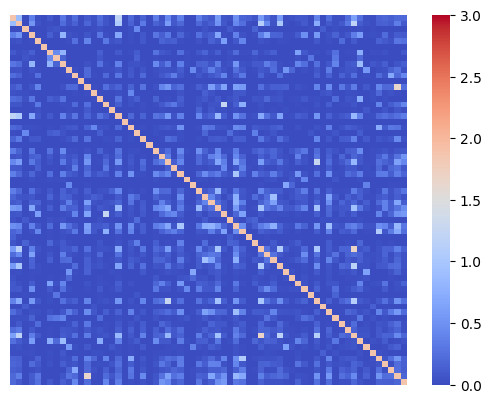

In [22]:
dataset = "elevators"
epoch = 49
K_zz = np.load(f"noise/learned/K_zz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v1/K_zz.npy")
K_zz = K_zz[0:64,0:64]
ax = plt.gca()
ax.axis("off")
heatmap(K_zz, ax=ax, cmap='coolwarm', cbar=True, vmin=0, vmax=3)
plt.savefig("noise/elevators_learned_noise.png", bbox_inches="tight")

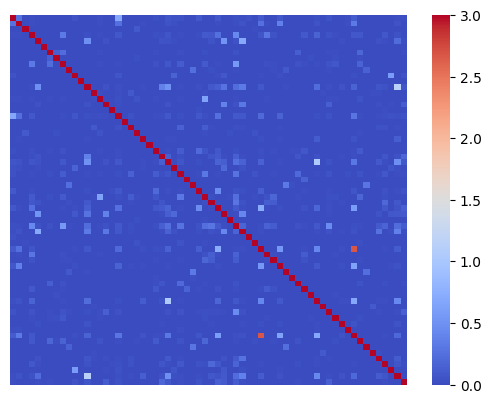

In [23]:
dataset = "elevators"
epoch = 49
K_zz = np.load(f"noise/fixed/K_zz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/K_zz.npy")
K_zz = K_zz[0:64,0:64]
ax = plt.gca()
ax.axis("off")
heatmap(K_zz, ax=ax, cmap='coolwarm', cbar=True, vmin=0, vmax=3)
plt.savefig("noise/elevators_fixed_noise.png", bbox_inches="tight")

In [ ]:
# import os
# api = wandb.Api()

# # runs2[(dataset, seed, num_inducing, train_frac, model)] = exp.run.id
# for model in models:
#     for dataset, _, _, _ in uci_info:
#         run = api.run(f"bogp/soft-gp-2/{runs2[(dataset, 6535, 512, 0.9, model)]}")
#         files = run.files()
#         image_files = [file for file in files if file.name.endswith('.png') or file.name.endswith('.jpg')]
#         for image in image_files:
#             iowrapper = image.download(replace=True, root="noise")
#             iteration = int((iowrapper.name.split("/")[-1]).split("_")[2])
#             new_name = f"noise/media/images/{model}_{dataset}_{iteration}.png"
#             os.rename(iowrapper.name, new_name)


In [ ]:
# for model in models:
#     for dataset, _, _, _ in uci_info:
#         run = api.run(f"bogp/soft-gp-2/{runs[(dataset, 6535, 512, 0.9, model, True)]}")
#         files = run.files()
#         image_files = [file for file in files if file.name.endswith('.png') or file.name.endswith('.jpg')]
#         for image in image_files:
#             iowrapper = image.download(replace=True, root="noise")
#             iteration = int((iowrapper.name.split("/")[-1]).split("_")[2])
#             new_name = f"noise/media/images/{model}_learnnoise_{dataset}_{iteration}.png"
#             os.rename(iowrapper.name, new_name)
